In [1]:
from tensorflow.keras.backend import clear_session

from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

from tensorflow.keras import utils
from tensorflow.keras.preprocessing import image

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import random
import math
import os

%matplotlib inline 

In [ ]:
!git clone https://github.com/a18091986/MachineLearning.git

Cloning into 'MachineLearning'...
remote: Enumerating objects: 3475, done.
remote: Total 3475 (delta 0), reused 0 (delta 0), pack-reused 3475
Receiving objects: 100% (3475/3475), 118.06 MiB | 26.22 MiB/s, done.
Resolving deltas: 100% (10/10), done.
Checking out files: 100% (6861/6861), done.


In [ ]:
train_path = '/content/MachineLearning/Datasets/Cars_2/all'
batch_size = 25
img_w = 96
img_h = 54


In [ ]:
#аугментация данных
data_gen = ImageDataGenerator(rescale = 1./255,
                              rotation_range = 10,
                              width_shift_range = 0.1,
                              height_shift_range = 0.1,
                              zoom_range = 0.1,
                              horizontal_flip = True,
                              fill_mode = 'nearest',
                              validation_split = 0.1)

In [ ]:
train_generator = data_gen.flow_from_directory(
    train_path,
    target_size = (img_w, img_h),
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle = True,
    subset = 'training')


val_generator = data_gen.flow_from_directory(
    train_path,
    target_size = (img_w, img_h),
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle = True,
    subset = 'validation'
)

Found 3086 images belonging to 3 classes.
Found 341 images belonging to 3 classes.


/content/MachineLearning/Datasets/Cars_2/all/Renault/car__1029.png
/content/MachineLearning/Datasets/Cars_2/all/Ferrari/car_Ferrari__190.png
/content/MachineLearning/Datasets/Cars_2/all/Mercedes/car__3.png
/content/MachineLearning/Datasets/Cars_2/all/Renault/car__349.png
/content/MachineLearning/Datasets/Cars_2/all/Ferrari/car_Ferrari__937.png
/content/MachineLearning/Datasets/Cars_2/all/Mercedes/car__605.png
/content/MachineLearning/Datasets/Cars_2/all/Renault/car__121.png
/content/MachineLearning/Datasets/Cars_2/all/Ferrari/car_Ferrari__1303.png
/content/MachineLearning/Datasets/Cars_2/all/Mercedes/car__473.png


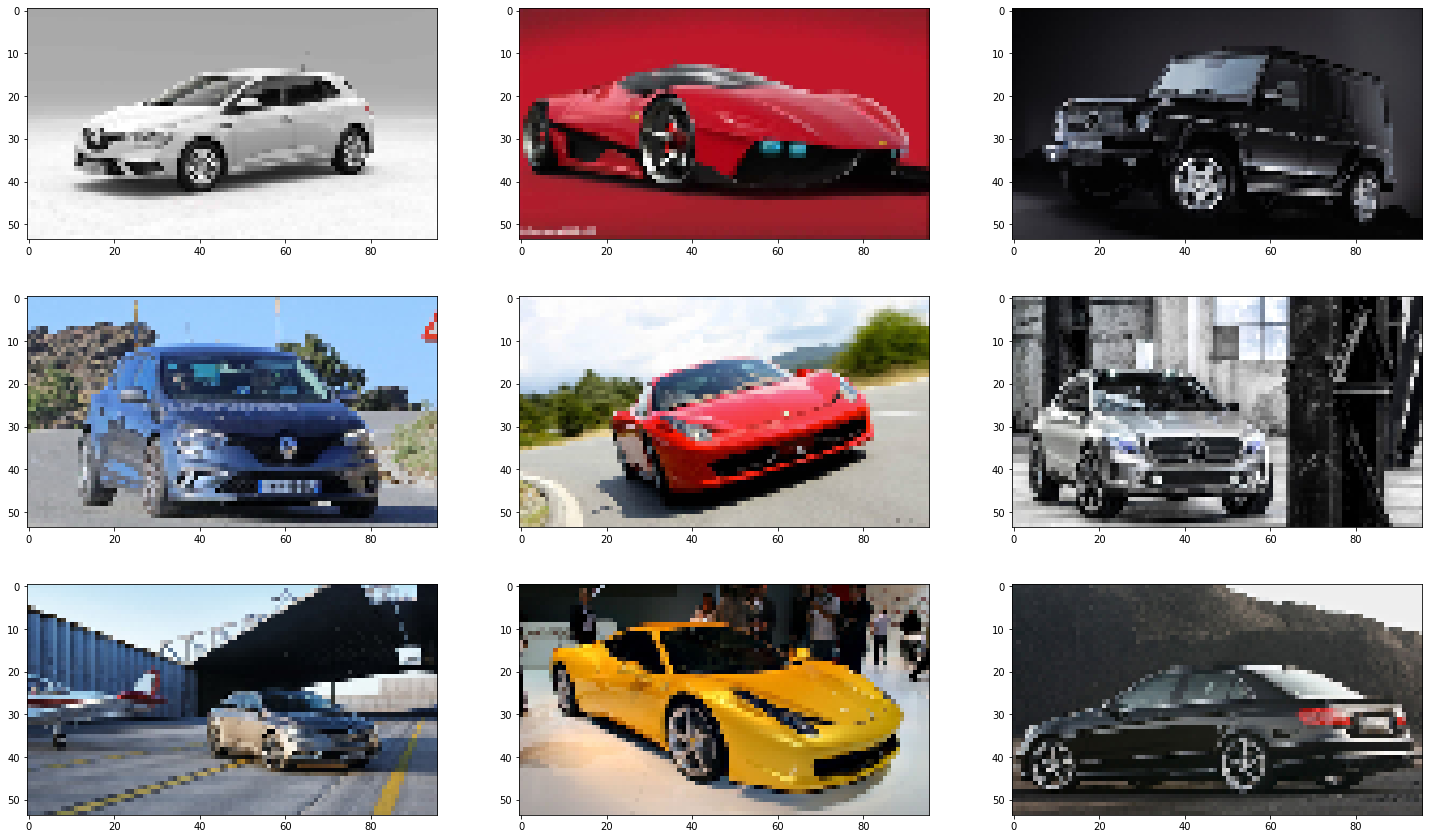

In [ ]:
fig, axs = plt.subplots(3, 3, figsize=(25, 15)) #Создаем полотно из 3 графиков
for i in range(3): #Проходим по всем классам
  for j in range(3):
    car_path = train_path + '/' + os.listdir(train_path)[j] + '/'
    img_path = car_path + random.choice(os.listdir(car_path))
    print(img_path)
    axs[i, j].imshow(image.load_img(img_path, target_size=(img_h, img_w))) #Отображение фотографии

plt.show() #Показываем изображения

In [ ]:
#Создаем последовательную модель
model = Sequential()
#Первый сверточный слой
model.add(Conv2D(256, (3, 3), padding='same', activation='relu', input_shape=(img_w, img_h, 3)))
#Второй сверточный слой
model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))
#Третий сверточный слой
model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
#Слой регуляризации Dropout
model.add(Dropout(0.2))
#Четвертый сверточный слой
model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))
#Слой регуляризации Dropout
model.add(Dropout(0.2))
#Пятый сверточный слой
model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
#Шестой сверточный слой
model.add(Conv2D(1024, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))
#Слой регуляризации Dropout
model.add(Dropout(0.2))
#Слой преобразования двумерных данных в одномерные 
model.add(Flatten())
#Полносвязный слой
model.add(Dense(2048, activation='relu'))
#Полносвязный слой
model.add(Dense(4096, activation='relu'))
#Вызодной полносвязный слой
model.add(Dense(len(train_generator.class_indices), activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.0001), metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = val_generator, 
    validation_steps = val_generator.samples // batch_size,
    epochs=45,
    verbose=1
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/45
123/123 [==============================] - 40s 226ms/step - loss: 0.9843 - accuracy: 0.4848 - val_loss: 0.9370 - val_accuracy: 0.5508
Epoch 2/45
123/123 [==============================] - 26s 215ms/step - loss: 0.9196 - accuracy: 0.5472 - val_loss: 0.9039 - val_accuracy: 0.5600
Epoch 3/45
123/123 [==============================] - 26s 213ms/step - loss: 0.8958 - accuracy: 0.5688 - val_loss: 0.9004 - val_accuracy: 0.5569
Epoch 4/45
123/123 [==============================] - 26s 212ms/step - loss: 0.8378 - accuracy: 0.6148 - val_loss: 0.8570 - val_accuracy: 0.6154
Epoch 5/45
123/123 [==============================] - 26s 213ms/step - loss: 0.8050 - accuracy: 0.6344 - val_loss: 0.8621 - val_accuracy: 0.6369
Epoch 6/45
123/123 [==============================] - 26s 213ms/step - loss: 0.7824 - accuracy: 0.6537 - val_loss: 0.7707 - val_accuracy: 0.6892
Epoch 7/45
123/123 [==============================] - 26s 212ms/step - loss: 0.7649 - accuracy: 0.6612 - val_loss: 0.8577 - val_ac

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 96, 54, 256)       7168      
                                                                 
 conv2d_1 (Conv2D)           (None, 96, 54, 256)       590080    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 18, 256)      0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 18, 256)       590080    
                                                                 
 dropout (Dropout)           (None, 32, 18, 256)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 18, 256)       590080    
                                                        

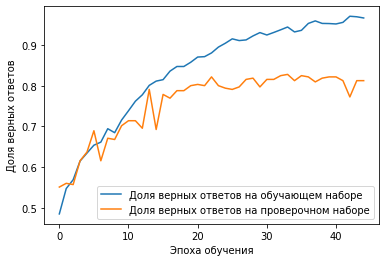

In [ ]:
#Оображаем график точности обучения
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()